In [1]:
# Cell 1: imports & basic setup

import os
import time
from dataclasses import dataclass
from typing import List, Dict, Any

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

%matplotlib inline

# quick dataset info (optional, doar ca să vezi distribuția)
for c in os.listdir("data/flower_photos"):
    print(c, len(os.listdir(f"data/flower_photos/{c}")))

data_dir = "data/flower_photos"
image_size = 192   # <- marit de la 128
batch_size = 32

default_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Default device:", default_device)

daisy 633
dandelion 898
roses 641
sunflowers 699
tulips 799
Default device: cuda


In [2]:
# Cell 2: dataloaders & augmentations

def get_dataloaders():
    # Augmentare destul de puternică, dar rezonabilă
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=image_size, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.15),
        transforms.RandomRotation(20),
        transforms.ColorJitter(
            brightness=0.25,
            contrast=0.25,
            saturation=0.25,
            hue=0.08,
        ),
        transforms.RandomAdjustSharpness(sharpness_factor=1.4, p=0.3),
        transforms.RandomAutocontrast(p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ])

    # dataset de bază pentru split de indecși
    base_dataset = datasets.ImageFolder(root=data_dir)
    class_names = base_dataset.classes
    num_classes = len(class_names)

    print("Classes:", class_names)
    print("Number of images:", len(base_dataset))

    train_ratio = 0.8
    train_size = int(train_ratio * len(base_dataset))
    val_size = len(base_dataset) - train_size

    train_subset_base, val_subset_base = random_split(
        base_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42),
    )

    train_indices = train_subset_base.indices
    val_indices = val_subset_base.indices

    full_train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
    full_val_dataset = datasets.ImageFolder(root=data_dir, transform=val_transform)

    train_dataset = Subset(full_train_dataset, train_indices)
    val_dataset = Subset(full_val_dataset, val_indices)

    print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    print("Number of train batches:", len(train_loader))
    print("Number of val batches:", len(val_loader))

    return train_loader, val_loader, class_names, num_classes


# creezi loader-ele o singură dată
train_loader, val_loader, class_names, num_classes = get_dataloaders()


Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Number of images: 3670
Train size: 2936, Val size: 734
Number of train batches: 92
Number of val batches: 23


In [3]:
# Cell 3: FlexibleCNN model

def get_activation(name: str):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    if name == "tanh":
        return nn.Tanh()
    if name == "leakyrelu":
        return nn.LeakyReLU(0.1)
    raise ValueError(f"Unknown activation {name}")


class FlexibleCNN(nn.Module):
    """
    Model flexibil:
    - 0–4 convolutional layers
    - opțional BatchNorm
    - opțional MaxPooling
    - 1–2 fully connected (hidden) layers
    """

    def __init__(
        self,
        num_classes: int,
        num_conv_layers: int = 3,
        num_hidden_layers: int = 1,
        hidden_dim: int = 256,
        use_batchnorm: bool = True,
        use_pooling: bool = True,
        activation: str = "relu",
    ):
        super().__init__()

        self.num_conv_layers = num_conv_layers
        self.num_hidden_layers = num_hidden_layers
        self.use_batchnorm = use_batchnorm
        self.use_pooling = use_pooling
        self.activation = get_activation(activation)

        layers = []
        in_channels = 3
        out_channels = 32

        # feature extractor
        if num_conv_layers > 0:
            for _ in range(num_conv_layers):
                layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
                if use_batchnorm:
                    layers.append(nn.BatchNorm2d(out_channels))
                layers.append(self.activation)
                if use_pooling:
                    layers.append(nn.MaxPool2d(2))

                in_channels = out_channels
                out_channels *= 2

            layers.append(nn.AdaptiveAvgPool2d((4, 4)))
            self.features = nn.Sequential(*layers)

            last_channels = in_channels
            fc_in_dim = last_channels * 4 * 4
        else:
            self.features = nn.Identity()
            fc_in_dim = 3 * image_size * image_size

        self.flatten = nn.Flatten()

        # classifier
        drop_p = 0.3  # un pic mai mic decât 0.5

        fc_layers = []
        if num_hidden_layers == 1:
            fc_layers.append(nn.Linear(fc_in_dim, hidden_dim))
            fc_layers.append(self.activation)
            fc_layers.append(nn.Dropout(drop_p))
            fc_layers.append(nn.Linear(hidden_dim, num_classes))
        elif num_hidden_layers == 2:
            fc_layers.append(nn.Linear(fc_in_dim, hidden_dim))
            fc_layers.append(self.activation)
            fc_layers.append(nn.Dropout(drop_p))
            fc_layers.append(nn.Linear(hidden_dim, hidden_dim // 2))
            fc_layers.append(self.activation)
            fc_layers.append(nn.Dropout(drop_p))
            fc_layers.append(nn.Linear(hidden_dim // 2, num_classes))
        else:
            raise ValueError("num_hidden_layers must be 1 or 2")

        self.classifier = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


# sanity check
test_model = FlexibleCNN(num_classes=num_classes, num_conv_layers=2, num_hidden_layers=1)
print(test_model)


FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
  )
)


In [4]:
# Cell 4: training / evaluation helpers

def train_one_epoch(model, dataloader, criterion, optimizer, device, l1_lambda: float = 0.0):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    start_time = time.time()

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        if l1_lambda > 0.0:
            l1_norm = 0.0
            for p in model.parameters():
                l1_norm += p.abs().sum()
            loss = loss + l1_lambda * l1_norm

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total
    epoch_time = time.time() - start_time
    return epoch_loss, epoch_acc, epoch_time


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            running_total += labels.size(0)

    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total
    return epoch_loss, epoch_acc


def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_labels, all_preds


def plot_history(history, title_prefix=""):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Loss
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Accuracy per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_confusion(all_labels, all_preds, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    plt.figure(figsize=(6, 6))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def print_model_parameters(model):
    print("\n Model parameters (weights & biases)")
    for name, param in model.named_parameters():
        print(f"{name}: shape={tuple(param.shape)}")


In [5]:
# Cell 5: ExperimentConfig & experiment list

@dataclass
class ExperimentConfig:
    name: str
    num_conv_layers: int
    num_hidden_layers: int
    hidden_dim: int
    use_batchnorm: bool
    use_pooling: bool
    activation: str
    learning_rate: float
    l2_lambda: float
    l1_lambda: float
    num_epochs: int
    patience: int = 5
    label_smoothing: float = 0.0
    use_scheduler: bool = False


def get_experiments() -> List[ExperimentConfig]:
    return [
        ExperimentConfig(
            name="0",
            num_conv_layers=0,
            num_hidden_layers=2,
            hidden_dim=512,
            use_batchnorm=False,
            use_pooling=False,
            activation="relu",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=10,
        ),
        ExperimentConfig(
            name="1",
            num_conv_layers=1,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=False,
            use_pooling=True,
            activation="relu",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=10,
        ),
        ExperimentConfig(
            name="2",
            num_conv_layers=2,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=False,
            use_pooling=True,
            activation="relu",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=10,
        ),
        ExperimentConfig(
            name="3",
            num_conv_layers=2,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=False,
            use_pooling=True,
            activation="relu",
            learning_rate=3e-4,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=12,
        ),
        ExperimentConfig(
            name="4",
            num_conv_layers=3,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=3e-4,
            l2_lambda=5e-4,
            l1_lambda=0.0,
            num_epochs=15,
        ),
        ExperimentConfig(
            name="5",
            num_conv_layers=3,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=True,
            use_pooling=True,
            activation="leakyrelu",
            learning_rate=3e-4,
            l2_lambda=5e-4,
            l1_lambda=0.0,
            num_epochs=15,
        ),
        ExperimentConfig(
            name="6",
            num_conv_layers=4,
            num_hidden_layers=1,
            hidden_dim=512,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=3e-4,
            l2_lambda=1e-3,
            l1_lambda=0.0,
            num_epochs=15,
        ),
        ExperimentConfig(
            name="7",
            num_conv_layers=2,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=False,
            use_pooling=False,
            activation="relu",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=8,
        ),
        ExperimentConfig(
            name="8",
            num_conv_layers=3,
            num_hidden_layers=1,
            hidden_dim=256,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=3e-4,
            l2_lambda=5e-4,
            l1_lambda=1e-5,
            num_epochs=15,
        ),
        ExperimentConfig(
            name="9",
            num_conv_layers=0,
            num_hidden_layers=2,
            hidden_dim=512,
            use_batchnorm=False,
            use_pooling=False,
            activation="tanh",
            learning_rate=1e-3,
            l2_lambda=1e-4,
            l1_lambda=0.0,
            num_epochs=10,
        ),
        ExperimentConfig(
            name="10",
            num_conv_layers=4,
            num_hidden_layers=1,
            hidden_dim=512,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=2e-4,
            l2_lambda=7e-4,
            l1_lambda=1e-5,
            num_epochs=25,
        ),
        ExperimentConfig(
            name="11",
            num_conv_layers=4,
            num_hidden_layers=2,
            hidden_dim=512,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=1.5e-4,
            l2_lambda=6e-4,
            l1_lambda=5e-6,
            num_epochs=30,
        ),
        ExperimentConfig(
            name="12",
            num_conv_layers=4,
            num_hidden_layers=1,
            hidden_dim=512,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=1.8e-4,
            l2_lambda=5e-4,
            l1_lambda=0.0,
            num_epochs=40,
            patience=8,
            label_smoothing=0.05,
            use_scheduler=True,
        ),
        # noul experiment mai agresiv
        ExperimentConfig(
            name="14",
            num_conv_layers=4,
            num_hidden_layers=2,
            hidden_dim=640,
            use_batchnorm=True,
            use_pooling=True,
            activation="relu",
            learning_rate=1.5e-4,
            l2_lambda=4e-4,
            l1_lambda=1e-6,
            num_epochs=50,
            patience=10,
            label_smoothing=0.02,
            use_scheduler=True,
        ),
    ]


experiments = get_experiments()
experiments


[ExperimentConfig(name='0', num_conv_layers=0, num_hidden_layers=2, hidden_dim=512, use_batchnorm=False, use_pooling=False, activation='relu', learning_rate=0.001, l2_lambda=0.0001, l1_lambda=0.0, num_epochs=10, patience=5, label_smoothing=0.0, use_scheduler=False),
 ExperimentConfig(name='1', num_conv_layers=1, num_hidden_layers=1, hidden_dim=256, use_batchnorm=False, use_pooling=True, activation='relu', learning_rate=0.001, l2_lambda=0.0001, l1_lambda=0.0, num_epochs=10, patience=5, label_smoothing=0.0, use_scheduler=False),
 ExperimentConfig(name='2', num_conv_layers=2, num_hidden_layers=1, hidden_dim=256, use_batchnorm=False, use_pooling=True, activation='relu', learning_rate=0.001, l2_lambda=0.0001, l1_lambda=0.0, num_epochs=10, patience=5, label_smoothing=0.0, use_scheduler=False),
 ExperimentConfig(name='3', num_conv_layers=2, num_hidden_layers=1, hidden_dim=256, use_batchnorm=False, use_pooling=True, activation='relu', learning_rate=0.0003, l2_lambda=0.0001, l1_lambda=0.0, num_

In [6]:
# Cell 6: run_experiment & compare_cpu_gpu

def run_experiment(
    cfg: ExperimentConfig,
    train_loader: DataLoader,
    val_loader: DataLoader,
    class_names: List[str],
    num_classes: int,
    device: torch.device,
) -> Dict[str, Any]:
    print("\n" + "=" * 80)
    print(f"Starting experiment: {cfg.name} on device {device}")
    print("=" * 80)

    model = FlexibleCNN(
        num_classes=num_classes,
        num_conv_layers=cfg.num_conv_layers,
        num_hidden_layers=cfg.num_hidden_layers,
        hidden_dim=cfg.hidden_dim,
        use_batchnorm=cfg.use_batchnorm,
        use_pooling=cfg.use_pooling,
        activation=cfg.activation,
    ).to(device)

    print(model)

    criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)

    optimizer = optim.Adam(
        model.parameters(),
        lr=cfg.learning_rate,
        weight_decay=cfg.l2_lambda,
    )

    scheduler = None
    if cfg.use_scheduler:
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=cfg.num_epochs,
            eta_min=cfg.learning_rate * 0.1,
        )

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "epoch_time": [],
    }

    best_val_loss = float("inf")
    best_val_acc = 0.0
    best_state_dict = None
    best_epoch = 0
    no_improve_epochs = 0

    total_start = time.time()

    for epoch in range(1, cfg.num_epochs + 1):
        print(f"\nEpoch {epoch}/{cfg.num_epochs}")
        print("-" * 40)

        train_loss, train_acc, train_time = train_one_epoch(
            model, train_loader, criterion, optimizer, device, l1_lambda=cfg.l1_lambda
        )
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["epoch_time"].append(train_time)

        print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
        print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")
        print(f"Epoch train time: {train_time:.1f} s")

        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_state_dict = model.state_dict()
            best_epoch = epoch
            no_improve_epochs = 0
            print(f"new best model (val_loss={best_val_loss:.4f}, val_acc={best_val_acc:.4f})")
        else:
            no_improve_epochs += 1
            print(f"no improvement for {no_improve_epochs} epoch(s)")

        # scheduler step la final de epoch
        if scheduler is not None:
            scheduler.step()

        if no_improve_epochs >= cfg.patience:
            print(f" early stopping triggered at epoch {epoch}")
            break

    total_time = time.time() - total_start
    print(f"\nTRAINING FINISHED FOR {cfg.name}")
    print(f"Best epoch: {best_epoch} / {cfg.num_epochs}")
    print(f"Best val_loss: {best_val_loss:.4f} | Best val_acc: {best_val_acc:.4f}")
    print(f"Total training time: {total_time:.1f} s")

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    all_labels, all_preds = get_predictions(model, val_loader, device)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"Macro-F1 on validation: {macro_f1:.4f}")

    print_model_parameters(model)

    plot_history(history, title_prefix=cfg.name)
    plot_confusion(all_labels, all_preds, class_names, title=f"{cfg.name} - Confusion Matrix")

    result = {
        "config": cfg,
        "history": history,
        "macro_f1": macro_f1,
        "best_val_acc": best_val_acc,
        "best_val_loss": best_val_loss,
        "best_epoch": best_epoch,
        "total_time": total_time,
    }
    return result


def compare_cpu_gpu(cfg: ExperimentConfig, train_loader, val_loader, class_names, num_classes):
    cpu_device = torch.device("cpu")
    gpu_device = torch.device("cuda") if torch.cuda.is_available() else None

    print("\n===== CPU vs GPU comparison for config:", cfg.name, "=====")

    print("\n### Running on CPU ###")
    res_cpu = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, cpu_device)

    if gpu_device is not None:
        print("\n### Running on GPU ###")
        res_gpu = run_experiment(cfg, train_loader, val_loader, class_names, num_classes, gpu_device)

        print("\n=== CPU vs GPU summary ===")
        print(f"CPU total time: {res_cpu['total_time']:.1f} s")
        print(f"GPU total time: {res_gpu['total_time']:.1f} s")
        speedup = res_cpu["total_time"] / res_gpu["total_time"] if res_gpu["total_time"] > 0 else None
        if speedup is not None:
            print(f"Approx. speedup: {speedup:.2f}x")
    else:
        print("No GPU available for comparison.")



Starting experiment: 14 on device cuda
FlexibleCNN(
  (activation): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256

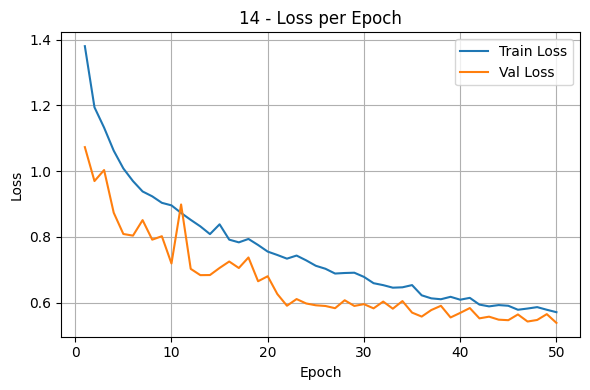

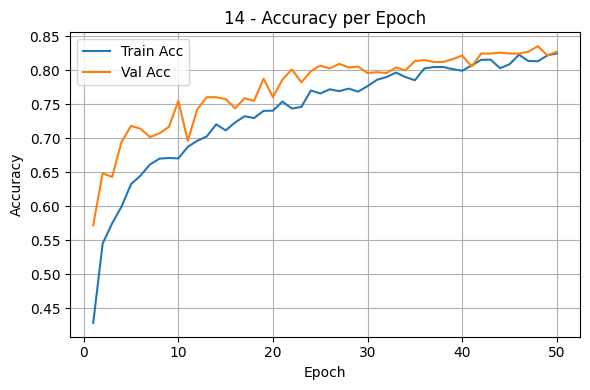

<Figure size 600x600 with 0 Axes>

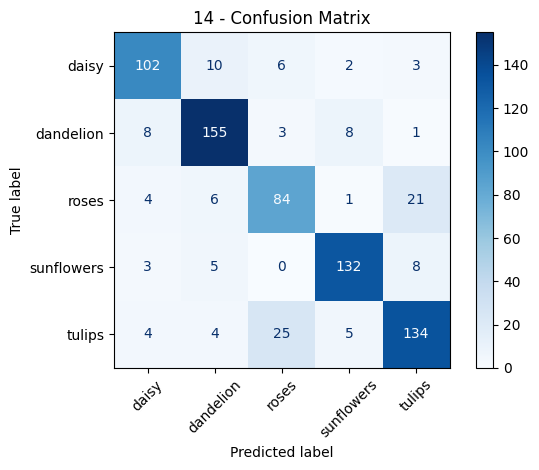

0.8219412184414443

In [7]:
cfg14 = next(e for e in experiments if e.name == "14")
result14 = run_experiment(cfg14, train_loader, val_loader, class_names, num_classes, default_device)
result14["macro_f1"]